## Diffusion Model for FastMRI - Sampling

Code to use a trained DDPM for generating new brain MR images of different contrasts.

In [1]:
from tqdm import tqdm
from datetime import datetime
import os

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

from fastmri_brain_data_builder import get_labels_key
from unet import real_to_complex, complex_to_real, ContextUnet, BigContextUnet
from ddpm import DDPM

from skimage.metrics import peak_signal_noise_ratio
import imageio

device = torch.device("cuda")

### Load the model

In [2]:
save_dir = './models/May05_0847_mag'
chkpoint= 850

complex_in = False
num_feat = 64
n_T = 500
img_shape = (160, 160)

Num params: 61723137


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

labels_key = get_labels_key('../LSS/lss_jcb/aniket/FastMRI brain data/')
num_classes = len(labels_key)
weights_fname = f'/ddpm_ep{chkpoint}.pth'

# eps_model = BigContextUnet(complex_in=complex_in, n_classes=4)
eps_model = ContextUnet(complex_in=complex_in, n_feat=num_feat, n_classes=num_classes)

ddpm = DDPM(eps_model=eps_model, betas=(1e-4, 0.02), n_T=n_T, complex_in=complex_in, device=device)
ddpm.to(device)

ddpm.load_state_dict(torch.load(save_dir + weights_fname))
print("Num params:", count_parameters(ddpm))

### Generate samples

In [3]:
ddpm.eval()
with torch.no_grad():
    out_samples_list, nT_list = ddpm.sample_all((1, img_shape[-2], img_shape[-1]))
    out_samples = out_samples_list[-1]

100%|██████████| 500/500 [01:41<00:00,  4.92it/s]


In [4]:
print("Sample shape:", out_samples[0].shape)

Sample shape: (1, 160, 160)


### Save samples from many timesteps as images

In [5]:
gif_save_dir = save_dir + '/sample_gif'
if not(os.path.exists(gif_save_dir)):
    os.makedirs(gif_save_dir)

plt.rcParams.update({'font.size': 18})

num_frames = len(out_samples_list)
with tqdm(total=num_frames, position=0, leave=True) as pbar:
    for j in range(num_frames):
        t = nT_list[j]
        pbar.set_description(f"Saving image for timestep {t}")
        # print("Saving image", j, "for gif")
        fig, ax = plt.subplots(1, num_classes, figsize=(20,10))
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.01)
        for i in range(num_classes):
            img = out_samples_list[j][i,0]
            if complex_in: img = np.abs(img)
            
            if t==0:
                ax[i].imshow(img, cmap='gray', vmin=0., vmax=1.)
            else:
                ax[i].imshow(img, cmap='gray')
            ax[i].axis('off')
            ax[i].set_title(f'{labels_key[i]} sample')
        fig.suptitle(f'Samples at time step {t}')
        plt.savefig(gif_save_dir+f'/{j}.png')
        plt.close()
        pbar.update(1)
    
pbar.close()

Saving image for timestep 0: 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]  


### Create animated GIF of diffusion process

In [6]:
filenames = [ f'/{i}.png' for i in range(num_frames) ] + [f'/{num_frames-1}.png']*15

gif_path = save_dir+'/sample.gif'
with imageio.get_writer(gif_path, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(gif_save_dir + filename)
        writer.append_data(image)

/tmp/ipykernel_4133/1158097366.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(gif_save_dir + filename)


### Display samples at final timestep

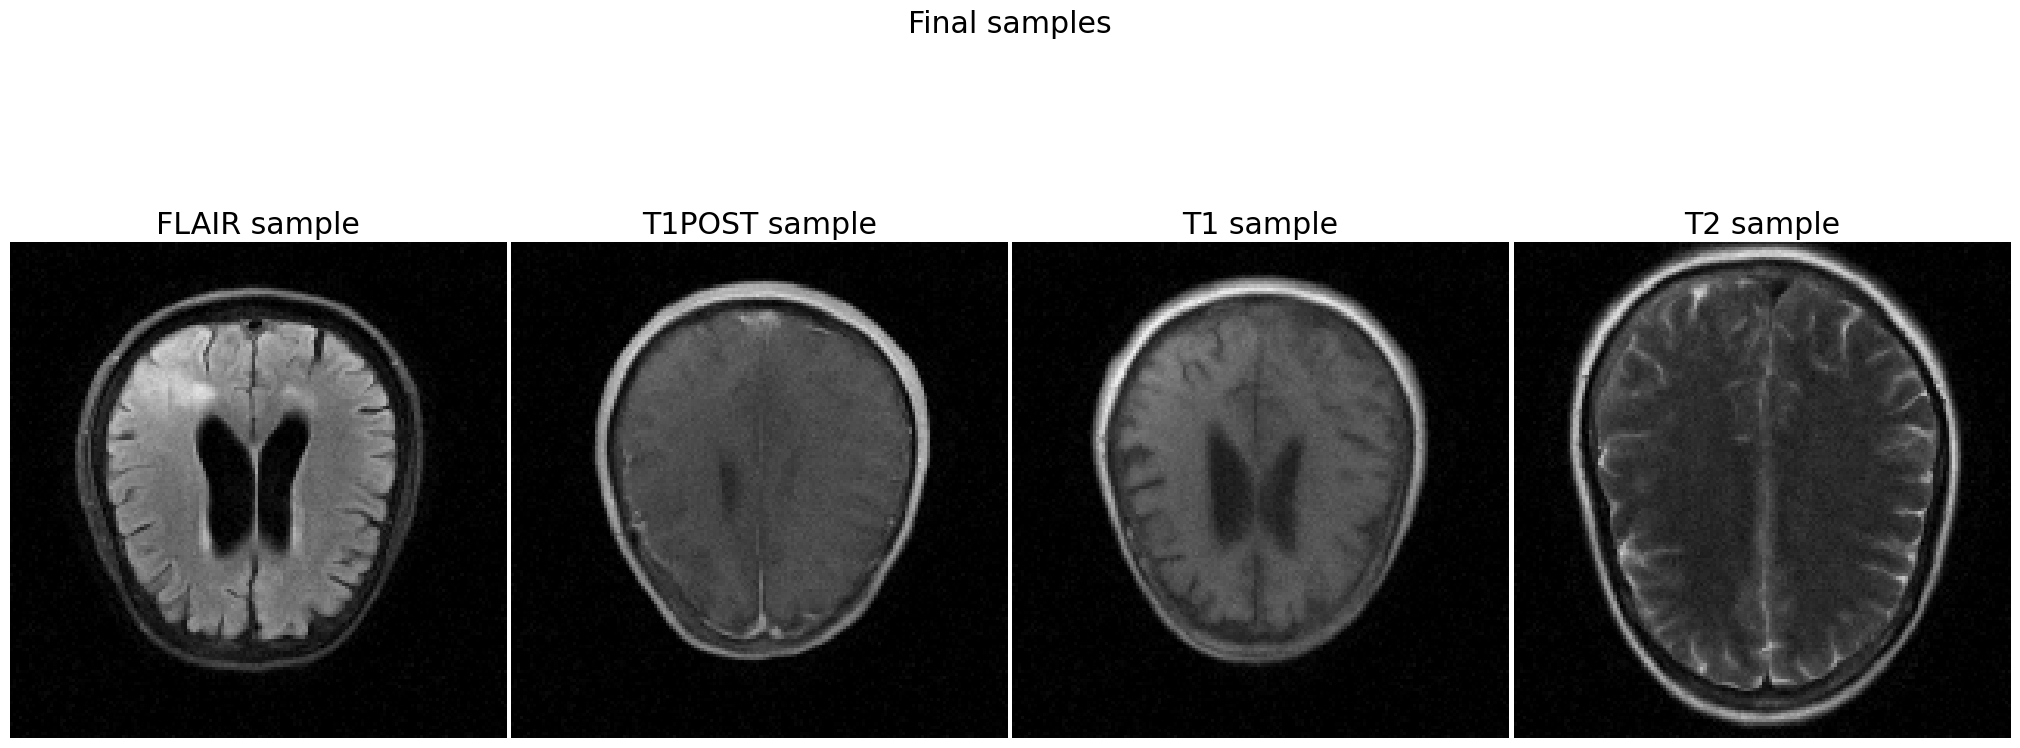

In [7]:
fig, ax = plt.subplots(1, num_classes, figsize=(20,10))
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.01)
for i in range(num_classes):
    img = out_samples_list[-1][i,0]
    if complex_in: img = np.abs(img)   
    # img = np.abs(img)   
    ax[i].imshow(img, cmap='gray', vmin=0., vmax=1.)
    ax[i].axis('off')
    ax[i].set_title(f'{labels_key[i]} sample')
fig.suptitle('Final samples')
    
plt.savefig(save_dir+f'/sample_all_contrasts_{chkpoint}.png')
plt.show()